<a href="https://colab.research.google.com/github/starlingomez/preworkmac/blob/master/FEBRERO_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nba_api


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 3.8 MB/s eta 0:00:00


#Malik Monk

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301073    2    0    0    1    0    2    1     0     1    0    1    0   
1  0022301047   10    3    1    4    3   13    5     0     2    1    0    0   
2  0022301042   11    4    1    4    1   11    4     0     5    0    3    3   
3  0022301020    0    5    0    1    1   11    0     0     2    0    0    0   
4  0022301005   20    4    1    1    2   13    6     1     7    1    7    7   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0           2            3        2        1        3          0  
1         -22           17       13        7       14          2  
2           9           19       15        8       15          1  
3         -22            6        5        6        1          0  
4          -9           25       24        5       21          2  


<ipython-input-4-6e94bc7e3faf>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  2.5638
RMSE: 1.6012
R^2:  0.3259


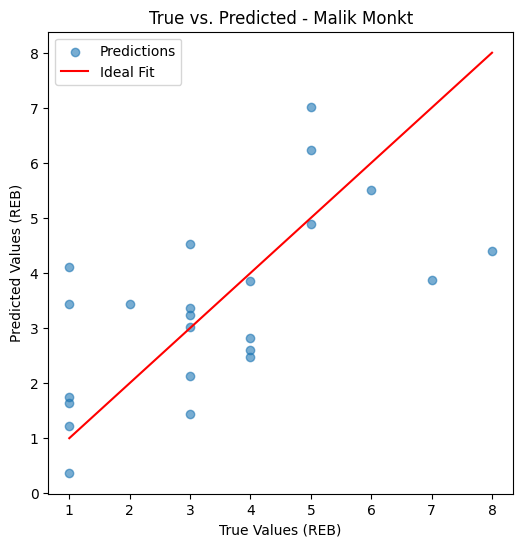


Using last 5-game averages for Malik Monk:
   HOME   PTS  AST  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  20.4  8.0  0.8  2.8  17.0  8.4   1.6   6.4  0.8  2.8  2.0        -2.0

Predicted REB for Malik Monk: 4.60
The model predicts that Malik Monk will go OVER 3.5 in today's game.


In [ ]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Malik Monk's player ID
Jugador_id = players.find_players_by_full_name("Malik Monk")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Malik Monk.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Malik Monkt')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 3.5  # Example threshold
print(f"\nUsing last 5-game averages for Malik Monk:")
print(today_game_df)
print(f"\nPredicted REB for Malik Monk: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Malik Monk will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Malik Monk will go UNDER {threshold} in today's game.")


#Nick Richards

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301159    7    1    1    2    1    4    3     0     0    0    1    1   
1  0022301144    8    1    0    7    2    4    4     0     0    0    0    0   
2  0022301135   10    1    1    4    1    6    4     0     0    0    2    2   
3  0022301079    8    0    1    2    0    6    4     0     0    1    0    0   
4  0022301062   12    0    0    8    0    7    6     0     0    0    1    0   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0           1           10        8        3        9          1  
1         -12           16        9        8       15          0  
2          11           15       11        5       14          1  
3         -12           10        8        2       10          2  
4         -11           20       12        8       20          0  

XGBRegressor Pe

<ipython-input-5-5e8eb34d08ac>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


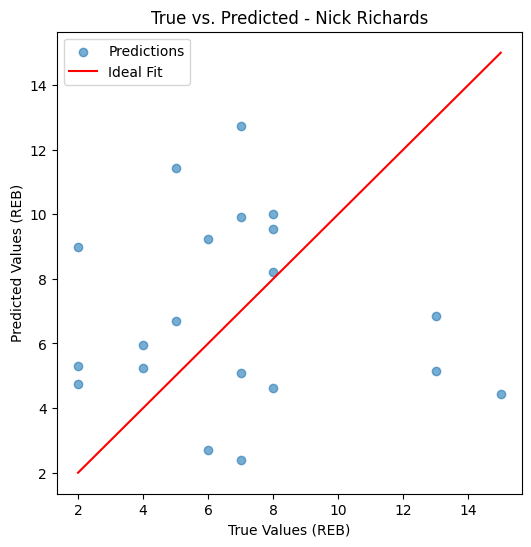


Using last 5-game averages for Malik Monk:
   HOME  PTS  AST  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  9.6  0.6  0.0  2.2  7.6  3.8   0.0   0.2  1.0  3.0  2.0        -0.6

Predicted REB for Nick Richards: 11.75
The model predicts that Nick Richards will go OVER 9.5 in today's game.


In [ ]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Malik Monk's player ID
Jugador_id = players.find_players_by_full_name("Nick Richards")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Nick Richards.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Nick Richards')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 9.5  # Example threshold
print(f"\nUsing last 5-game averages for Malik Monk:")
print(today_game_df)
print(f"\nPredicted REB for Nick Richards: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Nick Richards will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Nick Richards will go UNDER {threshold} in today's game.")


#Mason Plumlee

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301199    9    4    1   13    3   13    3     0     3    2    4    3   
1  0022301184    3    2    0    4    2    2    1     0     0    0    2    1   
2  0022301165   12    4    1   12    2    9    4     0     1    0    4    4   
3  0022301156    2    0    0    0    0    0    0     0     0    0    2    2   
4  0022301132    6    2    0    5    1    4    3     0     0    0    0    0   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -20           26       13       17       22          3  
1         -15            9        5        6        7          0  
2          -6           28       16       16       24          1  
3           7            2        2        0        2          0  
4           9           13        8        7       11          0  

XGBRegressor Pe

<ipython-input-7-7de33704efab>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


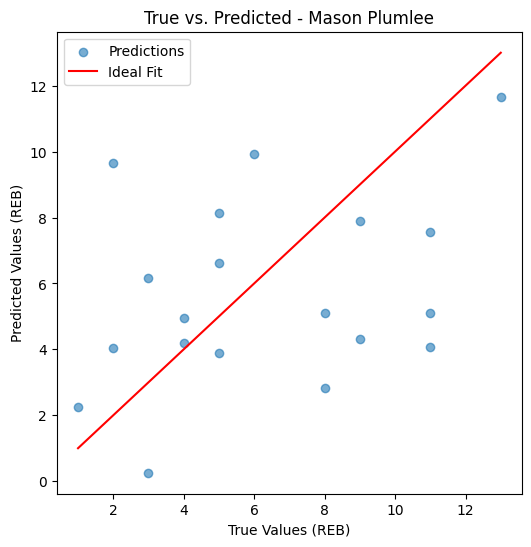


Using last 5-game averages for Mason Plumlee:
   HOME  PTS  AST  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  3.8  1.4  0.2  0.8  2.6  1.2   0.0   0.0  1.6  1.8  1.4         1.8

Predicted REB for Mason Plumlee: 2.03
The model predicts that Mason Plumlee will go UNDER 6.5 in today's game.


In [ ]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Malik Monk's player ID
Jugador_id = players.find_players_by_full_name("Mason Plumlee")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Mason Plumlee.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Mason Plumlee')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 6.5  # Example threshold
print(f"\nUsing last 5-game averages for Mason Plumlee:")
print(today_game_df)
print(f"\nPredicted REB for Mason Plumlee: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Mason Plumlee will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Mason Plumlee will go UNDER {threshold} in today's game.")


#Devin Booker

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301194   23    7    1    4    1   16    6     3     8    0   10    8   
1  0022301185   21    6    0    4    4   12    7     2     4    0    5    5   
2  0022301165   37    4    1    1    1   24   13     5    12    1    6    6   
3  0022301156   12    5    2    3    3   11    1     0     4    0   11   10   
4  0022301138   25    7    1    3    4   16    9     0     6    0    8    7   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          20           34       30       11       27          1  
1          -1           31       27       10       25          0  
2           9           42       41        5       38          2  
3          -7           20       17        8       15          2  
4          -6           35       32       10       28          1  

XGBRegressor Pe

<ipython-input-9-01ecbc966c9a>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


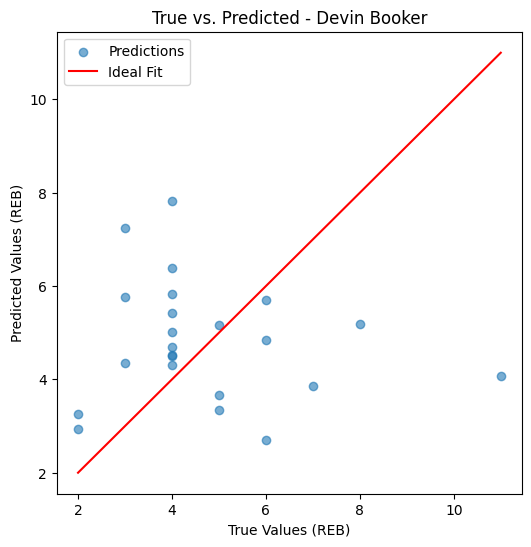


Using last 5-game averages for Devin Booker:
   HOME   PTS  AST  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  28.0  7.8  0.6  4.2  19.8  9.6   2.8   8.4  0.2  6.6  6.0         2.6

Predicted REB for Devin Booker: 5.73
The model predicts that Devin Booker will go OVER 4.5 in today's game.


In [ ]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Devin Booker's player ID
Jugador_id = players.find_players_by_full_name("Devin Booker")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Devin Booker.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Devin Booker')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 4.5  # Example threshold
print(f"\nUsing last 5-game averages for Devin Booker:")
print(today_game_df)
print(f"\nPredicted REB for Devin Booker: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Devin Booker will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Devin Bookerwill go UNDER {threshold} in today's game.")


#Grayson Allen

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301194   20    1    2    6    0   11    8     3     3    0    1    1   
1  0022301185   19    4    0    3    3   12    6     4     8    0    3    3   
2  0022301165    6    1    0    4    0    5    2     2     5    0    0    0   
3  0022301156    9    2    3    6    0   13    3     0     8    0    4    3   
4  0022301138   11    1    2    5    3   11    4     3    10    2    0    0   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          15           27       21        7       26          2  
1           3           26       23        7       22          0  
2          18           11        7        5       10          0  
3          -2           17       11        8       15          3  
4          -4           17       12        6       16          4  

XGBRegressor Pe

<ipython-input-11-7245fdfb5ddc>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


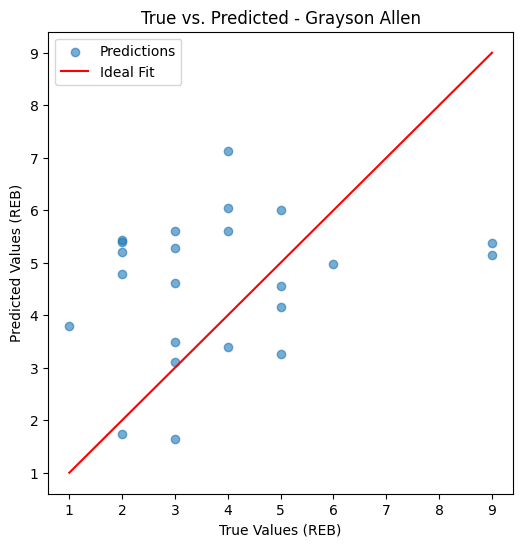


Using last 5-game averages for Grayson Allen:
   HOME   PTS  AST  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  10.2  2.2  1.0  1.0  7.0  3.6   2.6   5.6  0.4  0.8  0.4         4.2

Predicted REB for Grayson Allen: 3.28
The model predicts that Grayson Allen will go UNDER 3.5 in today's game.


In [ ]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Grayson Allen's player ID
Jugador_id = players.find_players_by_full_name("Grayson Allen")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Grayson Allen.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Grayson Allen')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 3.5  # Example threshold
print(f"\nUsing last 5-game averages for Grayson Allen:")
print(today_game_df)
print(f"\nPredicted REB for Grayson Allen: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Grayson Allen will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Grayson Allen will go UNDER {threshold} in today's game.")


#Chris Paul

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301198    6    6    0    4    1   10    3     0     3    0    0    0   
1  0022301182    9    6    2    4    1    9    4     1     3    0    0    0   
2  0022301169    8    4    1    3    1    9    3     2     6    1    0    0   
3  0022301155   11    9    0    6    3   10    5     1     4    0    0    0   
4  0022301142   12    9    4    1    4   10    5     2     6    1    0    0   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -11           16       12       10       10          0  
1          -4           19       15       10       13          2  
2           3           15       12        7       11          2  
3          21           26       20       15       17          0  
4          15           22       21       10       13          5  

XGBRegressor Pe

<ipython-input-12-61ca22f1ec95>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


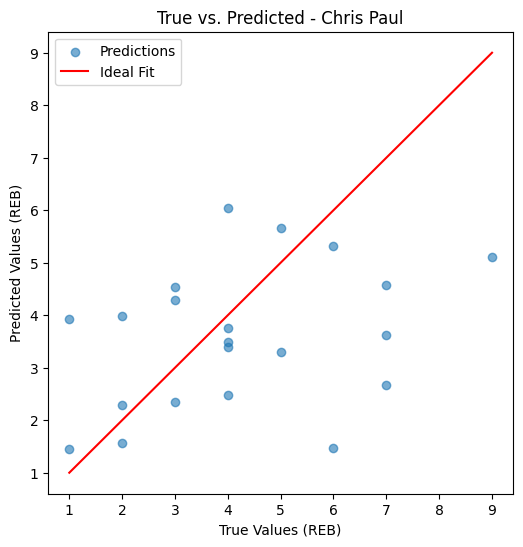


Using last 5-game averages for Chris Paul:
   HOME  PTS  AST  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  9.0  7.6  1.2  0.8  7.0  2.8   1.6   4.8  0.2  2.0  1.8         1.0

Predicted REB for Chris Paul: 2.58
The model predicts that Chris Paul will go UNDER 3.5 in today's game.


In [ ]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Chris Paul's player ID
Jugador_id = players.find_players_by_full_name("Chris Paul")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Chris Paul.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Chris Paul')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 3.5  # Example threshold
print(f"\nUsing last 5-game averages for Chris Paul:")
print(today_game_df)
print(f"\nPredicted REB for Chris Paul: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Chris Paul will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Chris Paul will go UNDER {threshold} in today's game.")


#Karl-Anthony Towns

In [2]:
!pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 16.4 MB/s eta 0:00:00


Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301194   10    2    0    6    5    8    3     1     4    0    4    3   
1  0022301178   11    8    0    5    3   11    4     1     6    1    2    2   
2  0022300881   14    1    0    4    1   12    5     0     3    2    6    4   
3  0022300873   18    8    0    9    3   18    7     2     7    0    2    2   
4  0022300862   19    5    1    6    3   17    7     1     6    0    5    4   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -18           18       12        8       16          0  
1          -4           24       19       13       16          1  
2           1           19       15        5       18          2  
3          14           35       26       17       27          0  
4           1           30       24       11       25          1  

XGBRegressor Pe

<ipython-input-14-f05dcfa8d963>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


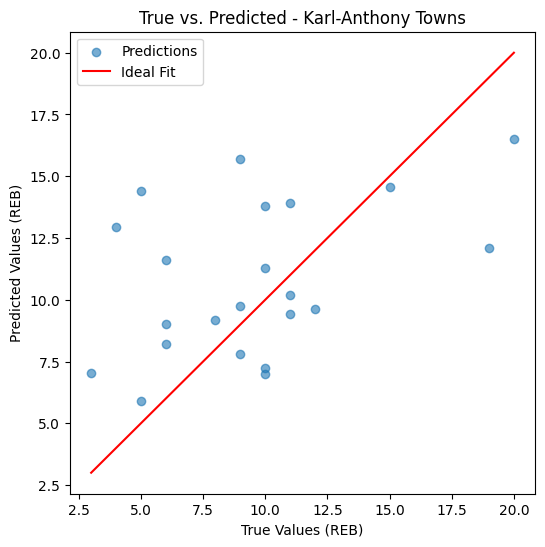


Using last 5-game averages for Karl-Anthony Towns:
   HOME   PTS  AST  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  18.4  3.4  1.2  2.2  15.4  7.2   0.6   2.8  0.6  3.8  3.4         4.0

Predicted REB for Karl-Anthony Towns: 12.27
The model predicts that Karl-Anthony Towns will go UNDER 13.5 in today's game.


In [ ]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Karl-Anthony Towns's player ID
Jugador_id = players.find_players_by_full_name("Karl-Anthony Towns")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Karl-Anthony Towns.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Karl-Anthony Towns')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 13.5  # Example threshold
print(f"\nUsing last 5-game averages for Karl-Anthony Towns:")
print(today_game_df)
print(f"\nPredicted REB for Karl-Anthony Towns: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Karl-Anthony Towns will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Karl-Anthony Towns will go UNDER {threshold} in today's game.")


#Jaden McDaniels

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301194    6    1    0    0    3    7    2     1     4    0    2    1   
1  0022301178   11    1    0    3    0    7    4     3     4    1    0    0   
2  0022301164    9    3    1    2    0    8    4     1     4    0    0    0   
3  0022301152    9    2    1    5    0    6    3     1     4    1    2    2   
4  0022301143   11    2    0    3    0    9    5     0     2    0    1    1   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -11            7        7        1        6          0  
1           8           15       12        4       14          1  
2         -17           14       12        5       11          1  
3         -10           16       11        7       14          2  
4           4           16       13        5       14          0  

XGBRegressor Pe

<ipython-input-3-f2c50040acc7>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


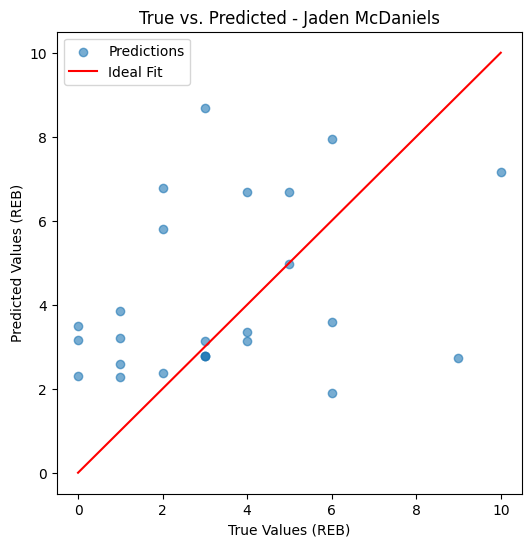


Using last 5-game averages for Jaden McDaniels:
   HOME   PTS  AST  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  12.8  2.8  2.2  1.2  8.4  4.4   1.6   3.0  0.6  2.6  2.4         9.4

Predicted REB for Jaden McDaniels: 4.49
The model predicts that Jaden McDaniels will go UNDER 6.5 in today's game.


In [3]:
!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Jaden McDaniels's player ID
Jugador_id = players.find_players_by_full_name("Jaden McDaniels")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Jaden McDaniels.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted - Jaden McDaniels')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 6.5  # Example threshold
print(f"\nUsing last 5-game averages for Jaden McDaniels:")
print(today_game_df)
print(f"\nPredicted REB for Jaden McDaniels: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Jaden McDaniels will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Jaden McDaniels will go UNDER {threshold} in today's game.")


#Anthony Edward

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301194   13    4    1    6    5    7    3     0     2    1    8    7   
1  0022301178   14    4    2    4    3   12    4     0     5    0    6    6   
2  0022301164   25    4    0    2    1   18    9     2     6    0    7    5   
3  0022301152   51    7    0    6    2   29   17     6    13    0   11   11   
4  0022301143   26    8    1    1    1   20    9     3     8    0    5    5   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -21           23       17       10       19          2  
1           0           22       18        8       18          2  
2         -16           31       29        6       27          0  
3           6           64       58       13       57          0  
4           2           35       34        9       27          1  


<ipython-input-4-160163453014>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  9.8908
RMSE: 3.1450
R^2:  -0.5695


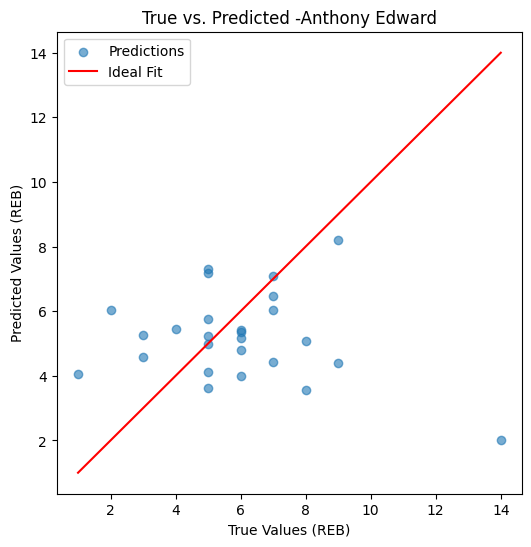


Using last 5-game averages for Anthony Edward:
   HOME   PTS  AST  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  29.4  7.2  0.8  3.8  20.0  9.8   3.2   8.6  1.6  8.2  6.6        12.0

Predicted REB for Anthony Edward: 4.93
The model predicts that Anthony Edward will go UNDER 5.5 in today's game.


In [4]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Jaden McDaniels's player ID
Jugador_id = players.find_players_by_full_name("Anthony Edward")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Anthony Edward.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted -Anthony Edward')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 5.5  # Example threshold
print(f"\nUsing last 5-game averages for Anthony Edward:")
print(today_game_df)
print(f"\nPredicted REB for Anthony Edward: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Anthony Edward will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Anthony Edward will go UNDER {threshold} in today's game.")


#Jamal Murray

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301193   21    4    0    6    2   14    7     3     7    1    4    4   
1  0022301180   35    4    1    5    1   26   14     5    11    0    2    2   
2  0022301164   20    6    0    4    4   13    8     4     6    0    0    0   
3  0022301154   28    4    4    2    1   20   11     4    10    4    4    2   
4  0022301130   16    6    0    3    3   11    6     2     4    1    2    2   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          27           31       25       10       27          1  
1          -4           44       39        9       40          1  
2           7           30       26       10       24          0  
3          22           34       32        6       30          8  
4          14           25       22        9       19          1  


<ipython-input-5-db455e53137a>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  8.7834
RMSE: 2.9637
R^2:  -0.4529


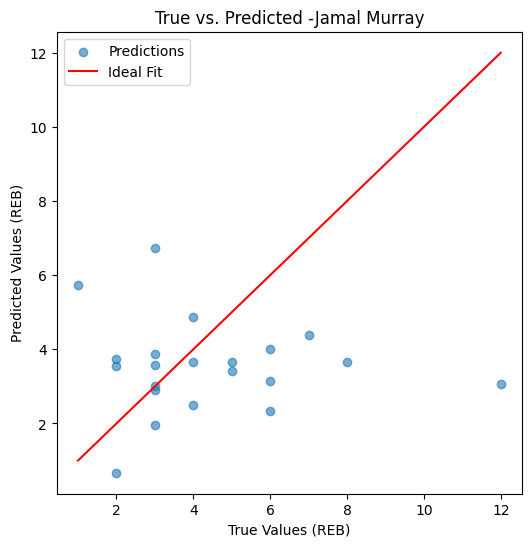


Using last 5-game averages for Jamal Murray:
   HOME   PTS  AST  STL  TOV   FGA   FGM  FG3M  FG3A  BLK  FTA  FTM  \
0     1  25.4  6.6  0.8  2.2  19.8  10.2   1.6   5.4  0.8  3.6  3.4   

   PLUS_MINUS  
0        -6.0  

Predicted REB for Jamal Murray: 2.90
The model predicts that Jamal Murraywill go UNDER 3.5 in today's game.


In [5]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Jaden McDaniels's player ID
Jugador_id = players.find_players_by_full_name("Jamal Murray")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'AJamal Murray.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted -Jamal Murray')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 3.5  # Example threshold
print(f"\nUsing last 5-game averages for Jamal Murray:")
print(today_game_df)
print(f"\nPredicted REB for Jamal Murray: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Jamal Murray will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Jamal Murraywill go UNDER {threshold} in today's game.")


#Wendell Carter Jr

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301191    7    0    0    2    0    3    3     1     1    0    0    0   
1  0022301171    4    0    0    0    0    3    2     0     1    0    0    0   
2  0022301162    9    0    0    3    1    9    3     1     4    0    2    2   
3  0022301150    7    2    1    6    2    7    3     1     3    0    0    0   
4  0022301136   11    3    2    8    0   11    5     1     6    1    0    0   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          27            9        7        2        9          0  
1          -2            4        4        0        4          0  
2         -14           12        9        3       12          0  
3         -11           15        9        8       13          1  
4           7           22       14       11       19          3  

XGBRegressor Pe

<ipython-input-7-e0b1d8fffbd8>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


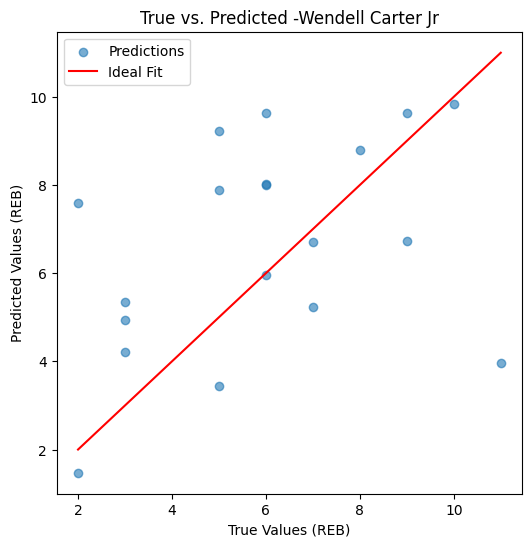


Using last 5-game averages for Wendell Carter Jr:
   HOME  PTS  AST  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  9.2  2.4  0.8  1.6  7.0  3.0   0.2   1.8  0.4  3.2  3.0       -10.0

Predicted REB for Wendell Carter Jr: 7.97
The model predicts that Wendell Carter Jrwill go OVER 6.5 in today's game.


In [7]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find JWendell Carter Jr's player ID
Jugador_id = players.find_players_by_full_name("Wendell Carter Jr")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Wendell Carter Jr.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'AST', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'REB'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (REB)')
plt.ylabel('Predicted Values (REB)')
plt.title('True vs. Predicted -Wendell Carter Jr')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'AST': avg_stats['AST'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 6.5  # Example threshold
print(f"\nUsing last 5-game averages for Wendell Carter Jr:")
print(today_game_df)
print(f"\nPredicted REB for Wendell Carter Jr: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Wendell Carter Jrwill go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Wendell Carter Jr will go UNDER {threshold} in today's game.")


#Trae Young

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301188   12   12    0    3    8    9    4     1     4    0    3    3   
1  0022301178   19    7    1    2    2   12    6     3     7    0    6    4   
2  0022301159   14   11    1    4    5    5    5     2     2    0    2    2   
3  0022300804   11    7    0    3    4   13    4     2     6    0    2    1   
4  0022300777   12   12    0    2    4   12    4     2     8    0    2    2   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -35           27       24       15       15          0  
1          16           28       26        9       21          1  
2          16           29       25       15       18          1  
3          -6           21       18       10       14          0  
4         -15           26       24       14       14          0  


<ipython-input-14-7ad61bf40042>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  21.2045
RMSE: 4.6048
R^2:  -0.2908


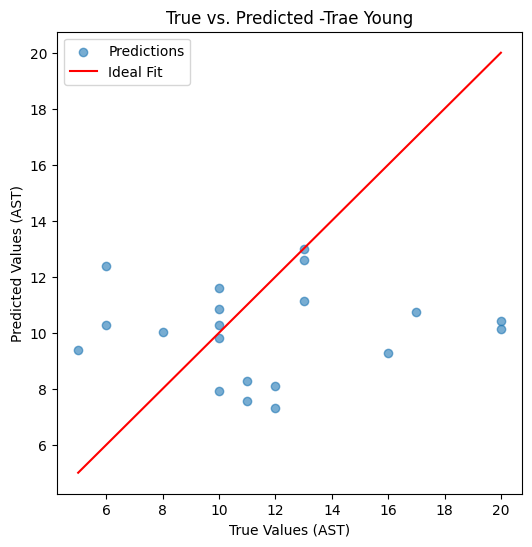


Using last 5-game averages for Trae Young:
   HOME   PTS  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  20.8  2.4  0.6  5.8  17.8  7.0   2.4   8.8  0.0  5.6  4.4        -7.8

Predicted AST for Trae Young: 9.50
The model predicts that Trae Young  will go UNDER 10.5 in today's game.


In [14]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Trae Young's player ID
Jugador_id = players.find_players_by_full_name("Trae Young")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Trae Young.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'AST'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (AST)')
plt.ylabel('Predicted Values (AST)')
plt.title('True vs. Predicted -Trae Young')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 10.5  # Example threshold
print(f"\nUsing last 5-game averages for Trae Young:")
print(today_game_df)
print(f"\nPredicted AST for Trae Young: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Trae Young  will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Trae Young  will go UNDER {threshold} in today's game.")


#Zion Williamson

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301195   12    8    2    8    4   13    4     0     1    0    5    4   
1  0022301182   26    3    6    3    2   26   11     1     2    1    6    3   
2  0022301170   31    6    3    4    4   21   13     0     1    1    5    5   
3  0022301157   22    3    1    7    2   18    7     0     0    1    9    8   
4  0022301138   29    7    1   10    4   21   11     0     0    5    8    7   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -21           28       20       16       20          2  
1          15           32       29        6       29          7  
2          16           41       37       10       35          4  
3          11           32       25       10       29          2  
4           7           46       36       17       39          6  


<ipython-input-16-312df37907ad>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  3.9868
RMSE: 1.9967
R^2:  0.8924


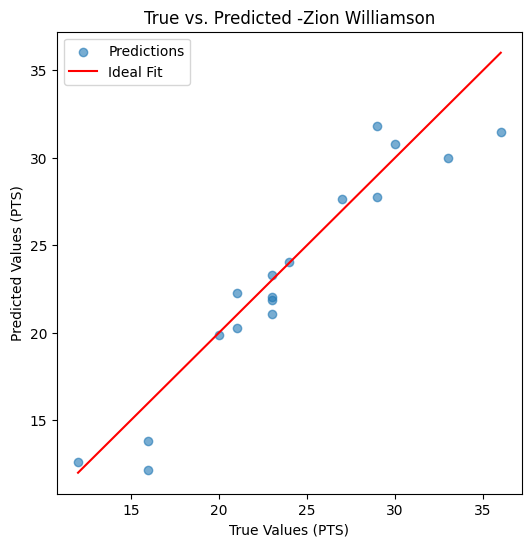


Using last 5-game averages for Zion Williamson:
   HOME  AST  REB  STL  TOV   FGA   FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  5.2  9.0  0.6  3.0  18.2  11.2   0.0   0.2  1.6  6.8  4.2        -2.4

Predicted AST for Zion Williamson: 26.01
The model predicts that Zion Williamson will go OVER 22.5 in today's game.


In [16]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Zion Williamson's player ID
Jugador_id = players.find_players_by_full_name("Zion Williamson")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Zion Williamson.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Zion Williamson')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 22.5  # Example threshold
print(f"\nUsing last 5-game averages for Zion Williamson:")
print(today_game_df)
print(f"\nPredicted AST for Zion Williamson: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Zion Williamson will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Zion Williamson will go UNDER {threshold} in today's game.")


#Pascal Siakam

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301188   28    1    1    6    2   18   13     1     2    0    2    1   
1  0022301174   19    1    0    6    0   15    7     2     3    0    4    3   
2  0022301146   16    3    0    9    3   10    6     0     0    2    4    4   
3  0022301133   18    1    0    8    0   15    7     1     3    0    4    3   
4  0022301116   21    2    0    5    1   10    8     1     1    0    5    4   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          27           35       29        7       34          1  
1         -12           26       20        7       25          0  
2          13           28       19       12       25          2  
3          -2           27       19        9       26          0  
4          -5           28       23        7       26          0  


<ipython-input-17-aad83103a288>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  3.4919
RMSE: 1.8687
R^2:  0.9205


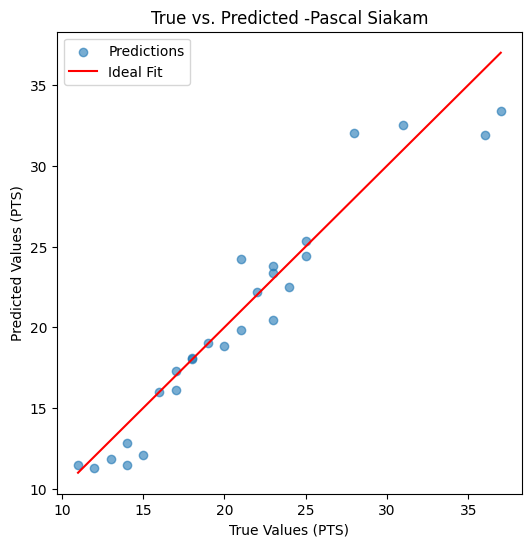


Using last 5-game averages for Pascal Siakam:
   HOME  AST  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  4.6  7.6  0.6  1.8  15.4  9.2   1.6   3.4  1.6  5.4  3.8         9.4

Predicted AST for Pascal Siakam: 24.15
The model predicts that Pascal Siakam will go OVER 21.5 in today's game.


In [17]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Zion Williamson's player ID
Jugador_id = players.find_players_by_full_name("Pascal Siakam")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Pascal Siakam.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Pascal Siakam')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 21.5  # Example threshold
print(f"\nUsing last 5-game averages for Pascal Siakam:")
print(today_game_df)
print(f"\nPredicted AST for Pascal Siakam: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Pascal Siakam will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Pascal Siakam will go UNDER {threshold} in today's game.")


#Mark Williams

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301216    4    1    1    3    1    4    2     0     0    2    0    0   
1  0022300281   11    0    0    6    1    6    4     0     0    0    4    3   
2  0022300266   12    1    1   12    0   12    5     0     0    3    2    2   
3  0022300057   12    0    1   12    0    9    5     0     0    0    2    2   
4  0022300248   12    1    1    6    1    6    5     0     0    1    2    2   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0           5            8        5        4        7          3  
1          -8           17       11        6       17          0  
2          -2           25       13       13       24          4  
3          -7           24       12       12       24          1  
4         -11           19       13        7       18          2  


<ipython-input-18-5eda33182cfb>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  5.5848
RMSE: 2.3632
R^2:  0.7826


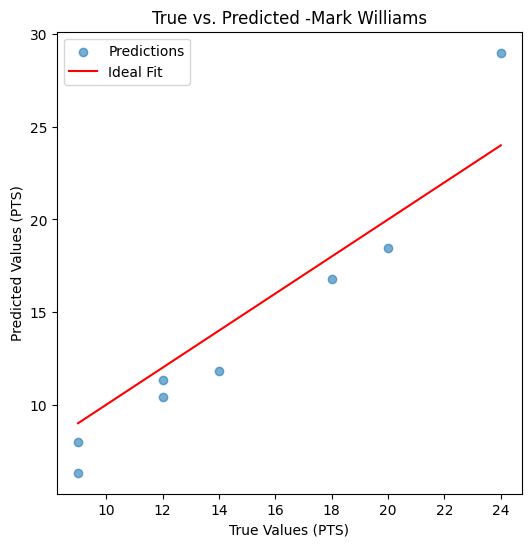


Using last 5-game averages for Mark Williams:
   HOME  AST   REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  3.6  10.8  0.8  1.2  14.8  7.6   0.0   0.0  2.0  5.4  4.2       -10.2

Predicted AST for Mark Williams: 18.51
The model predicts that Mark Williams will go OVER 18.5 in today's game.


In [18]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find ZMark Williams's player ID
Jugador_id = players.find_players_by_full_name("Mark Williams")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Mark Williams.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Mark Williams')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 18.5  # Example threshold
print(f"\nUsing last 5-game averages for Mark Williams:")
print(today_game_df)
print(f"\nPredicted PTS for Mark Williams: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Mark Williams will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Mark Williams will go UNDER {threshold} in today's game.")


#Josh Green

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301196    4    3    0    3    1    8    1     0     4    0    2    2   
1  0022301181    4    0    1    3    2    6    2     0     3    0    0    0   
2  0022301161    3    2    1    4    0    5    1     1     3    0    0    0   
3  0022300959    2    0    0    0    1    2    1     0     1    0    0    0   
4  0022300952   11    0    0    5    1    6    5     1     2    0    0    0   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -44           10        7        6        7          0  
1         -14            7        4        3        7          1  
2           7            9        5        6        7          1  
3           1            2        2        0        2          0  
4          -8           16       11        5       16          0  


<ipython-input-19-373fd13ac608>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  1.0147
RMSE: 1.0073
R^2:  0.9706


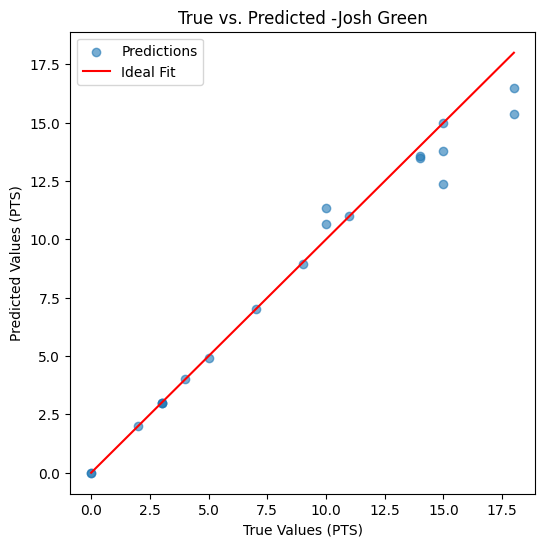


Using last 5-game averages for Josh Green:
   HOME  AST  REB  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  2.0  2.6  1.0  0.6  6.6  4.0   2.2   3.8  0.0  1.4  1.4        -7.4

Predicted PTS forJosh Green: 12.45
The model predicts thatJosh Green will go OVER 8.5 in today's game.


In [19]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Josh Green's player ID
Jugador_id = players.find_players_by_full_name("Josh Green")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Josh Green.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Josh Green')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 8.5  # Example threshold
print(f"\nUsing last 5-game averages for Josh Green:")
print(today_game_df)
print(f"\nPredicted PTS forJosh Green: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts thatJosh Green will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts thatJosh Green will go UNDER {threshold} in today's game.")


#Keon Ellis

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301200   13    2    3    3    1    9    4     3     6    2    2    2   
1  0022301185   17    1    2    3    0   11    7     2     6    0    1    1   
2  0022301170    5    0    0    1    0    5    2     1     3    0    0    0   
3  0022301153   26    5    2    6    5   17    9     8    15    2    0    0   
4  0022301141    6    1    0    2    2    7    2     2     6    1    0    0   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          30           18       15        5       16          5  
1         -13           21       18        4       20          2  
2          -5            6        5        1        6          0  
3          -4           37       31       11       32          4  
4          -9            9        7        3        8          1  

XGBRegressor Pe

<ipython-input-20-8e65f352f19a>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


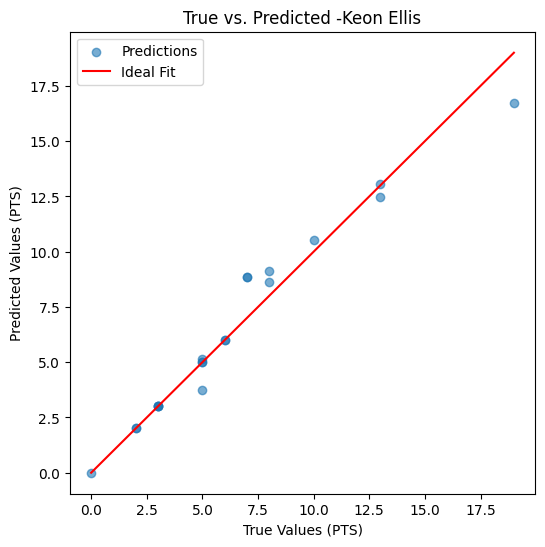


Using last 5-game averages for Keon Ellis:
   HOME  AST  REB  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  1.8  2.6  1.6  0.6  7.0  2.4   1.4   5.2  0.8  0.2  0.2       -10.6

Predicted PTS for Keon Ellis: 5.02
The model predicts that Keon Elliswill go UNDER 9.5 in today's game.


In [20]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Keon Ellis's player ID
Jugador_id = players.find_players_by_full_name("Keon Ellis")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Keon Ellis.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Keon Ellis')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 9.5  # Example threshold
print(f"\nUsing last 5-game averages for Keon Ellis:")
print(today_game_df)
print(f"\nPredicted PTS for Keon Ellis: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Keon Ellis will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Keon Elliswill go UNDER {threshold} in today's game.")
